
# Pneumonia classification

Download [pneumonia datatset form Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)


# Resources:

http://blog.root.cz/trpaslikuv-blog/rozpoznani-zapalu-plic-z-rtg-snimku-dil-prvni/

In [25]:
!pip install --user matplotlib seaborn opencv-python wandb vit-keras

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
import os
import glob
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import TensorBoard

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import Input, Model
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import cv2
from pathlib import Path
import datetime
from typing import Tuple
import copy

import training_tools
import wandb
import wandb.integration
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

from training_tools import evaluate_model
# sns.set_style('darkgrid')

In [28]:



wandb.login()
# wandb.init(project="pneumonia_classification")

True

In [29]:
# %load_ext tensorboard

## Data

In [30]:
# move data from server to scratch
# !mkdir -p $SCRATCHDIR/kaggle/chest_xray
# !rsync -ah --info=progress2 /auto/plzen4-ntis/projects/korpusy_cv/kaggle/chest_xray $SCRATCHDIR/kaggle/chest_xray
# !echo $SRATCHDIR

In [31]:
!ls /auto/plzen4-ntis/projects/korpusy_cv/kaggle/chest_xray

__MACOSX  chest_xray  test  train  val


In [32]:
# DATA_ROOT = '/kaggle/input/chest-xray-pneumonia/chest_xray'
DATA_ROOT = Path('/auto/plzen4-ntis/projects/korpusy_cv/kaggle/chest_xray')
# DATA_ROOT = Path(f'{os.getenv("SCRATCHDIR")}/kaggle/chest_xray')
# DATA_ROOT = Path(r"H:\medical\orig\kaggle-chest-xray-pneumonia/chest_xray")

DATA_TRAIN = DATA_ROOT/ "train"
DATA_VALID = DATA_ROOT/ "val"
DATA_TEST  = DATA_ROOT/ "test"

assert DATA_ROOT.exists()

In [33]:
for data_part in [DATA_TRAIN, DATA_VALID, DATA_TEST]:
    print(data_part.name)
    
    for dirpath in data_part.glob('*'):
        if not dirpath.is_file():
            count_files = len(list(dirpath.glob('*.*')))
            print(f"    {dirpath.name:9}: {count_files}")

train
    NORMAL   : 1341
    PNEUMONIA: 3875
val
    NORMAL   : 8
    PNEUMONIA: 8
test
    NORMAL   : 234
    PNEUMONIA: 390


Found 16 files belonging to 2 classes.


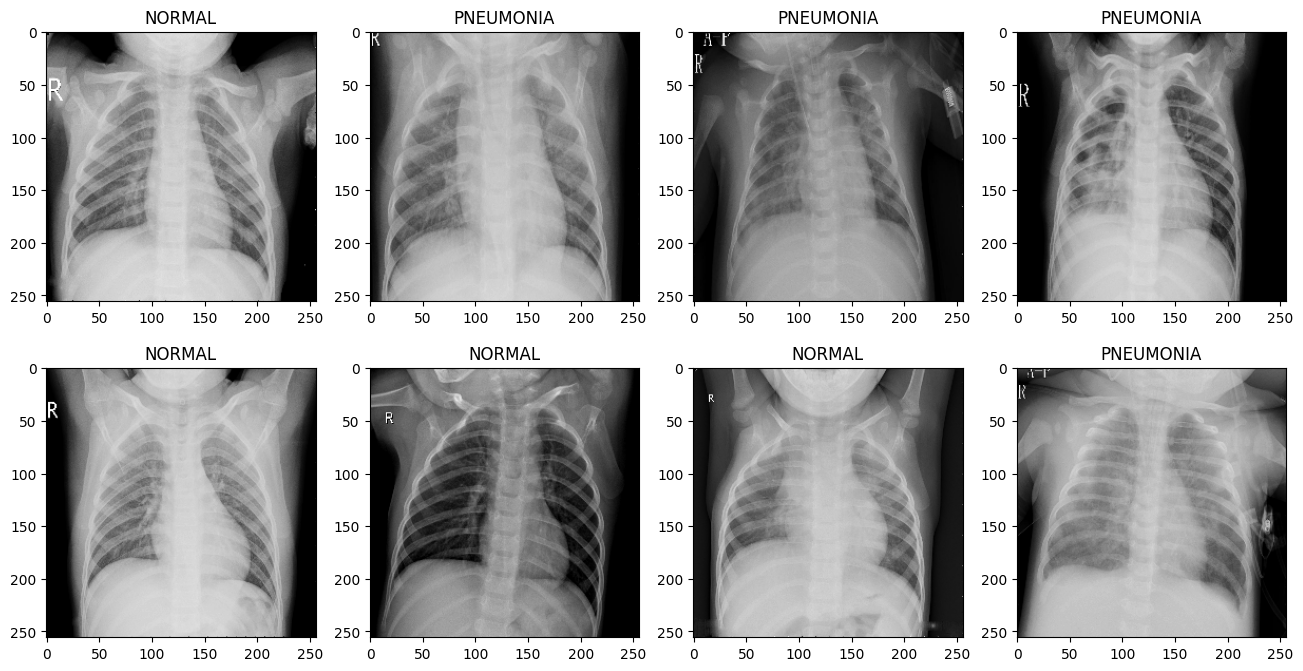

In [34]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16, 8))
    for n in range(8):
        ax = plt.subplot(2, 4, n+1)
        plt.imshow(image_batch[n], cmap='gray')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
#         plt.axis("off")

image_batch, label_batch = next(iter(image_dataset_from_directory(
    DATA_VALID,
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='grayscale')))

show_batch(image_batch.numpy(), label_batch.numpy())

In [35]:
LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = (224, 224)

def get_datasource(*data_dirs, flag=cv2.IMREAD_GRAYSCALE, max_image_number=None):
    x, y = list(), list()
    for data_dir in data_dirs:
        for i, label in enumerate(LABELS):
            path = os.path.join(data_dir, label)
            target = [0] * len(LABELS)
            target[i] = 1
            for j, img in enumerate(os.listdir(path)):
                if img.endswith(".jpeg"):
                    img_arr = cv2.imread(os.path.join(path, img), flag)
                    resized_arr = cv2.resize(img_arr, IMAGE_SIZE)
                    x.append(resized_arr)
                    y.append(target)
                    
    return np.array(x) / 255, np.array(y)




# def image_generator(ct_ids, batch_size = 32, sz = (256, 256)) -> Tuple[np.ndarray, np.ndarray]:
#     """Pick random slices from one random CT from given dataset."""

#     while True:

#         # pick random CT from available CT IDs
#         dataset = '3Dircadb1'
#         ct_id = np.random.choice(ct_ids, size = 1)[0]

#         data3dp = io3d.datasets.read_dataset(dataset, "data3d", ct_id)
#         segm3dp = io3d.datasets.read_dataset(dataset, "liver", ct_id)

#         slide_ids = list(range(data3dp.data3d.shape[0]))

#         #extract a random slides into batch
#         batch = np.random.choice(slide_ids , size = batch_size)

#         #variables for collecting batches of inputs and outputs
#         batch_x = []
#         batch_y = []

#         # preprocessing - resize, window and data type
#         data3d = preprocess(
#             data3dp.data3d,
#             img_rows=sz[0], img_cols=sz[1]
#             )
#         segm3d = preprocess(
#             segm3dp.data3d, is_mask=True,
#             img_rows=sz[0], img_cols=sz[1]
#             )

#         for slide_id in batch:

#             # #get the masks. Note that masks are png files
#             # mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
#             # mask = np.array(mask.resize(sz))

#             # preprocess the mask
#             mask = segm3d[slide_id,:,:]

#             # mask[mask >= 2] = 0
#             # mask[mask != 0 ] = 1


#             batch_y.append(mask)

#             #preprocess the raw images
#             raw = data3d[slide_id,:,:]
#             # print(raw.shape)

#             #set the number of channels to 3 by copying grayscale channel
#             raw = np.stack((raw[...,0],)*3, axis=-1)

#             batch_x.append(raw)

#         #preprocess a batch of images and masks
#         batch_x = np.array(batch_x) #/255.
#         batch_y = np.array(batch_y)
#         if len(batch_y.shape) < 3:
#             batch_y = np.expand_dims(batch_y, 3)
#         # batch_y = np.expand_dims(batch_y, )

#         yield (batch_x, batch_y)

In [36]:
def make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, divider=None, size_indicator=None):
    
    if divider:
        pass
    else:
        if size_indicator=="L":
            divider = 1
        elif size_indicator=="M":
            divider = 2
        elif size_indicator=="S":
            divider = 4
        elif size_indicator=="T":
            divider = 8
    
    print(x_train_orig.shape[0] / divider)
    x_train = copy.copy(x_train_orig[:int(x_train_orig.shape[0] / divider), ...])
#     x_valid = copy.copy(x_valid_orig[:int(x_valid_orig.shape[0] / 1), ...])
    y_train = copy.copy(y_train_orig[:int(y_train_orig.shape[0] / divider), ...])
#     y_valid = copy.copy(y_valid_orig[:int(y_valid_orig.shape[0] / 1), ...])
    x_valid = x_valid_orig
    y_valid = y_valid_orig
    
    return x_train, x_valid, y_train, y_valid

In [37]:
# x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = x_train, x_valid, y_train, y_valid

In [38]:
size_indicator="L"

In [39]:
x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(*get_datasource(DATA_TRAIN, DATA_VALID), test_size=0.2)
x_test, y_test = get_datasource(DATA_TEST)
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator="L")


x_train_orig = np.expand_dims(x_train_orig, axis=-1)
x_valid_orig = np.expand_dims(x_valid_orig, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

datagen = ImageDataGenerator(
#         rotation_range = 30,
#         zoom_range = 0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip = True,
        vertical_flip=False
)

datagen.fit(x_train_orig)

4185.0


In [46]:
x_train_orig.shape

(4185, 224, 224, 1)

In [41]:
size_indicator="L"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)

4185.0


In [42]:
x_valid.shape

(1047, 224, 224, 1)

In [43]:
x_train.shape

(4185, 224, 224, 1)

## Training

We use two different loggers

In [ ]:
# def evaluate_model(model, *, epochs=40, batch_size=32, forced_training=False, size_indicator=""):

#     print(f"=== MODEL EVALUATION =================================================\n")

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
#     model.summary()

#     MODEL_CHECKPOINT = f"./models/{model.name}.ckpt"
    
#     # Log dataset sizes to wandb
#     wandb.init(project="pneumonia_classification", name=model.name+str(size_indicator), config={"dataset_size": size_indicator})
#     wandb.log({
#         "training_samples": len(x_train),
#         "validation_samples": len(x_valid),
#         "test_samples": len(x_test)
#     })

#     if not os.path.exists(MODEL_CHECKPOINT) or forced_training:
#         print(f"\n--- Model training ---------------------------------------------------\n")
#         wandb.init(project="pneumonia_classification", name=model.name)
#         shutil.rmtree(MODEL_CHECKPOINT, ignore_errors=True)
        
#         # tensorboard callback
#         log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#         tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
#         callbacks_list = [
#             keras.callbacks.EarlyStopping(
#                 monitor='val_auc',
#                 patience=20),
#             keras.callbacks.ModelCheckpoint(
#                 filepath=MODEL_CHECKPOINT,
#                 monitor='val_auc',
#                 save_best_only=True,
#                 mode='max',
#                 verbose=1),
#             tensorboard_callback,
#             WandbMetricsLogger()
#         ]
#         history = model.fit(
#             datagen.flow(x_train, y_train, batch_size=batch_size),
#             epochs=epochs,
#             callbacks=callbacks_list,
#             validation_data=datagen.flow(x_valid, y_valid),
#             verbose=1)
#         wandb.finish()
#         print(f"\n--- Training history -------------------------------------------------\n")

#         fig, ax = plt.subplots(1, 2, figsize=(16, 4))
#         sns.lineplot(data={k: history.history[k] for k in ('loss', 'val_loss')}, ax=ax[0])
#         sns.lineplot(data={k: history.history[k] for k in history.history.keys() if k not in ('loss', 'val_loss')}, ax=ax[1])
#         plt.show()

#     else:
#         print(f"\n--- Model is already trainded ... loading ----------------------------\n")

#     model.load_weights(MODEL_CHECKPOINT)

#     print(f"\n--- Test Predictions and Metrics -------------------------------------\n")

#     y_pred = model.predict(x_test, verbose=0)

#     plt.figure(figsize=(6, 3))
#     heatmap = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1),  np.argmax(y_pred, axis=-1)), annot=True, fmt="d", cbar=True)
#     heatmap.yaxis.set_ticklabels(LABELS, rotation=90, ha='right')
#     heatmap.xaxis.set_ticklabels(LABELS, rotation=0, ha='right')
#     heatmap.axes.set_ylabel('True label')
#     heatmap.axes.set_xlabel('Predicted label')
#     plt.show()

#     print()
#     print(classification_report(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), target_names=LABELS, zero_division=0))

#     print(f"\n=== MODEL EVALUATION FINISHED ========================================")

## Model definition

In [ ]:
# model = create_model_ResNet50((1, 224,224), 2)

# Fully connected

In [21]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

def create_fully_connected_model(input_shape, classes=2):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    
    # Add Dense layers
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.3)(x)
    x = Dense(80, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Assuming input shape similar to ResNet50
input_shape = (224, 224, 3)
fully_connected_model = create_fully_connected_model(input_shape)

# Print summary to check the number of parameters
fully_connected_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 80)                12042320  
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2592      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528   

In [ ]:
evaluate_model(create_fully_connected_model(x_train.shape, 2), forced_training=True)


In [26]:
# x_train, x_valid, y_train, y_valid = train_test_split(*get_datasource(DATA_TRAIN, DATA_VALID), test_size=0.2)
# x_test, y_test = get_datasource(DATA_TEST)

# x_train = np.expand_dims(x_train, axis=-1)
# x_valid = np.expand_dims(x_valid, axis=-1)
# x_test  = np.expand_dims(x_test, axis=-1)

# datagen = ImageDataGenerator(
#         rotation_range = 30,
#         zoom_range = 0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip = True,
#         vertical_flip=False)

# datagen.fit(x_train)

# Shallow model

In [47]:
def create_model_ShallowCNN(X_shape, classes=2, name="ShallowCNN"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    inputs = Input(X_shape[-3:], name='inputs')

    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', name=f'conv_1')(inputs)
    x = layers.BatchNormalization(name=f'norm_1')(x)
    x = layers.Activation('relu', name=f'actv_1')(x)

    x = layers.MaxPooling2D((2, 2), name=f'pool_1')(x)

    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', name=f'conv_2')(x)
    x = layers.BatchNormalization(name=f'norm_2')(x)
    x = layers.Activation('relu', name=f'actv_2')(x)

    x = layers.MaxPooling2D((2, 2), name=f'pool_2')(x)

    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', name=f'conv_3')(x)
    x = layers.BatchNormalization(name=f'norm_3')(x)
    x = layers.Activation('relu', name=f'actv_3')(x)

    x = layers.GlobalAveragePooling2D(name=f'aver')(x)

    x = layers.Flatten(name="flatten")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

# Assuming input shape similar to ResNet50
input_shape = (224, 224, 3)
# create_model_ShallowCNN(input_shape, classes=2).summary()

523.125
=== MODEL EVALUATION =================================================

Model: "ShallowCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 norm_1 (BatchNormalization  (None, 224, 224, 64)      256       
 )                                                               
                                                                 
 actv_1 (Activation)         (None, 224, 224, 64)      0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 64)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 1

epoch/accuracy,▁▅▆█▃
epoch/auc,▁▄▅█▅
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▆▄▁▅
epoch/val_accuracy,▁▁▁▁▁
epoch/val_auc,█▁▁▁▁
epoch/val_loss,▁▄▅▇█
test_samples,▁
training_samples,▁
validation_samples,▁



--- Model training ---------------------------------------------------

Epoch 1/5
 6/17 [=========>....................] - ETA: 0s - loss: 0.5909 - accuracy: 0.7031 - auc: 0.7761WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0265s). Check your callbacks.


16/17 [===========================>..] - ETA: 0s - loss: 0.4808 - accuracy: 0.7515 - auc: 0.8505
Epoch 1: val_auc improved from -inf to 0.85559, saving model to ./models/ShallowCNNT.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNT.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNT.ckpt/assets


17/17 [==============================] - 6s 259ms/step - loss: 0.4640 - accuracy: 0.7610 - auc: 0.8603 - val_loss: 0.6527 - val_accuracy: 0.7584 - val_auc: 0.8556
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8432 - auc: 0.9308
Epoch 2: val_auc did not improve from 0.85559
17/17 [==============================] - 2s 97ms/step - loss: 0.3482 - accuracy: 0.8432 - auc: 0.9308 - val_loss: 1.7698 - val_accuracy: 0.7584 - val_auc: 0.7581
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8585 - auc: 0.9399
Epoch 3: val_auc did not improve from 0.85559
17/17 [==============================] - 2s 97ms/step - loss: 0.3121 - accuracy: 0.8585 - auc: 0.9399 - val_loss: 2.1974 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8719 - auc: 0.9534
Epoch 4: val_auc did not improve from 0.85559
17/17 [==============================] - 2s 96ms/step 

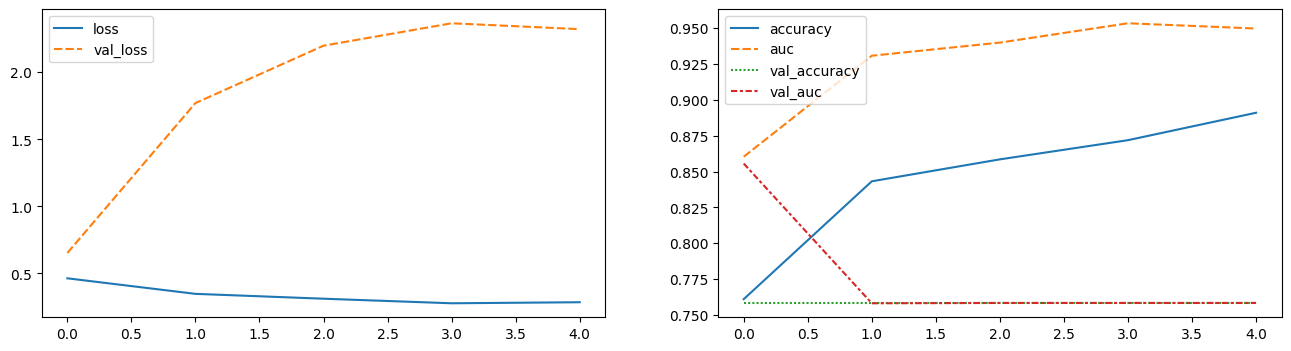

2024-05-29 22:14:49.915521: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ShallowCNNT.ckpt: FAILED_PRECONDITION: models/ShallowCNNT.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



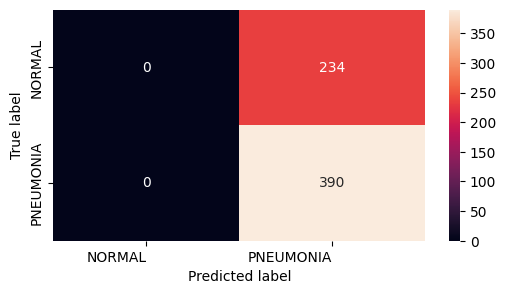


              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



epoch/accuracy,▁▅▆▇█
epoch/auc,▁▆▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/val_accuracy,▁▁▁▁▁
epoch/val_auc,█▁▁▁▁
epoch/val_loss,▁▆▇██
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [63]:
size_indicator="T"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ShallowCNN(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator, labels=LABELS, epochs=5)

1046.25
=== MODEL EVALUATION =================================================

Model: "ShallowCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 norm_1 (BatchNormalization  (None, 224, 224, 64)      256       
 )                                                               
                                                                 
 actv_1 (Activation)         (None, 224, 224, 64)      0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 64)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 1


--- Model training ---------------------------------------------------

Epoch 1/40
 5/33 [===>..........................] - ETA: 1s - loss: 0.6920 - accuracy: 0.5938 - auc: 0.6712WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0258s). Check your callbacks.


32/33 [============================>.] - ETA: 0s - loss: 0.4577 - accuracy: 0.7751 - auc: 0.8671
Epoch 1: val_auc improved from -inf to 0.75836, saving model to ./models/ShallowCNNS.ckpt


INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 6s 142ms/step - loss: 0.4538 - accuracy: 0.7801 - auc: 0.8701 - val_loss: 1.6286 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 2/40
32/33 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8600 - auc: 0.9370
Epoch 2: val_auc did not improve from 0.75836
33/33 [==============================] - 2s 72ms/step - loss: 0.3134 - accuracy: 0.8623 - auc: 0.9394 - val_loss: 2.6417 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 3/40
33/33 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8834 - auc: 0.9559
Epoch 3: val_auc did not improve from 0.75836
33/33 [==============================] - 2s 71ms/step - loss: 0.2701 - accuracy: 0.8834 - auc: 0.9559 - val_loss: 3.5261 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/40
32/33 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8846 - auc: 0.9521
Epoch 4: val_auc did not improve from 0.75836
33/33 [==============================] - 2s 72ms/st

INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 115ms/step - loss: 0.2622 - accuracy: 0.8987 - auc: 0.9592 - val_loss: 1.7798 - val_accuracy: 0.7584 - val_auc: 0.7591
Epoch 10/40
33/33 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9063 - auc: 0.9670
Epoch 10: val_auc did not improve from 0.75908
33/33 [==============================] - 2s 72ms/step - loss: 0.2333 - accuracy: 0.9063 - auc: 0.9670 - val_loss: 3.6103 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 11/40
33/33 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9197 - auc: 0.9732
Epoch 11: val_auc did not improve from 0.75908
33/33 [==============================] - 2s 72ms/step - loss: 0.2063 - accuracy: 0.9197 - auc: 0.9732 - val_loss: 2.3215 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 12/40
33/33 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9073 - auc: 0.9700
Epoch 12: val_auc improved from 0.75908 to 0.76228, saving model to ./models/ShallowCNNS.ckp

INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 114ms/step - loss: 0.2220 - accuracy: 0.9073 - auc: 0.9700 - val_loss: 1.5051 - val_accuracy: 0.7584 - val_auc: 0.7623
Epoch 13/40
33/33 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9207 - auc: 0.9730
Epoch 13: val_auc improved from 0.76228 to 0.85724, saving model to ./models/ShallowCNNS.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 114ms/step - loss: 0.2087 - accuracy: 0.9207 - auc: 0.9730 - val_loss: 1.2352 - val_accuracy: 0.7593 - val_auc: 0.8572
Epoch 14/40
33/33 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9063 - auc: 0.9705
Epoch 14: val_auc improved from 0.85724 to 0.95683, saving model to ./models/ShallowCNNS.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 126ms/step - loss: 0.2196 - accuracy: 0.9063 - auc: 0.9705 - val_loss: 0.2666 - val_accuracy: 0.8988 - val_auc: 0.9568
Epoch 15/40
33/33 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.8996 - auc: 0.9652
Epoch 15: val_auc did not improve from 0.95683
33/33 [==============================] - 2s 72ms/step - loss: 0.2418 - accuracy: 0.8996 - auc: 0.9652 - val_loss: 2.1088 - val_accuracy: 0.7593 - val_auc: 0.7608
Epoch 16/40
33/33 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9216 - auc: 0.9791
Epoch 16: val_auc did not improve from 0.95683
33/33 [==============================] - 2s 76ms/step - loss: 0.1868 - accuracy: 0.9216 - auc: 0.9791 - val_loss: 1.6831 - val_accuracy: 0.7593 - val_auc: 0.7826
Epoch 17/40
33/33 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9226 - auc: 0.9757
Epoch 17: val_auc did not improve from 0.95683
33/33 [==============================] - 2s 7

INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 114ms/step - loss: 0.1686 - accuracy: 0.9340 - auc: 0.9822 - val_loss: 0.2243 - val_accuracy: 0.8997 - val_auc: 0.9709
Epoch 23/40
33/33 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9187 - auc: 0.9745
Epoch 23: val_auc did not improve from 0.97091
33/33 [==============================] - 2s 72ms/step - loss: 0.2048 - accuracy: 0.9187 - auc: 0.9745 - val_loss: 4.9846 - val_accuracy: 0.2579 - val_auc: 0.2872
Epoch 24/40
33/33 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9235 - auc: 0.9771
Epoch 24: val_auc improved from 0.97091 to 0.98232, saving model to ./models/ShallowCNNS.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNS.ckpt/assets


33/33 [==============================] - 4s 115ms/step - loss: 0.1966 - accuracy: 0.9235 - auc: 0.9771 - val_loss: 0.1744 - val_accuracy: 0.9322 - val_auc: 0.9823
Epoch 25/40
33/33 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9331 - auc: 0.9812
Epoch 25: val_auc did not improve from 0.98232
33/33 [==============================] - 2s 73ms/step - loss: 0.1709 - accuracy: 0.9331 - auc: 0.9812 - val_loss: 0.5502 - val_accuracy: 0.7746 - val_auc: 0.9312
Epoch 26/40
33/33 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9388 - auc: 0.9844
Epoch 26: val_auc did not improve from 0.98232
33/33 [==============================] - 2s 73ms/step - loss: 0.1559 - accuracy: 0.9388 - auc: 0.9844 - val_loss: 1.2178 - val_accuracy: 0.7631 - val_auc: 0.8621
Epoch 27/40
33/33 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9130 - auc: 0.9715
Epoch 27: val_auc did not improve from 0.98232
33/33 [==============================] - 2s 7

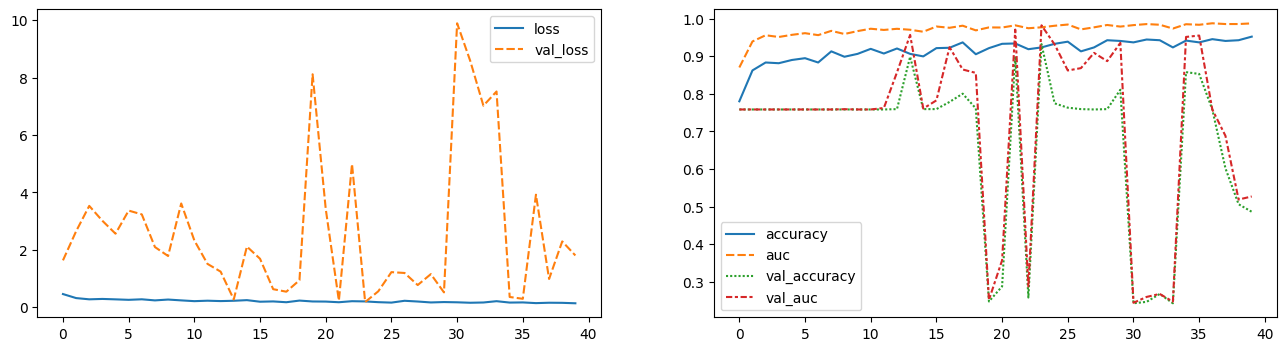

2024-05-29 22:18:39.749953: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ShallowCNNS.ckpt: FAILED_PRECONDITION: models/ShallowCNNS.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



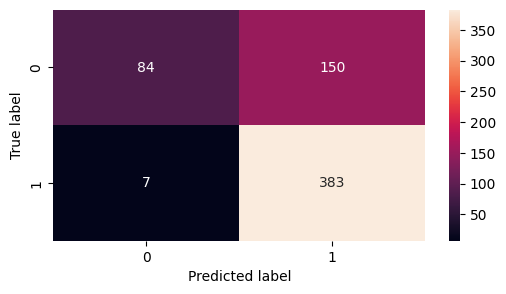


              precision    recall  f1-score   support

           0       0.92      0.36      0.52       234
           1       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



epoch/accuracy,▁▄▅▅▅▆▅▆▆▆▇▆▇▆▆▇▇▇▆▇▇▇▇▇▇▇▆▇██▇██▇█▇████
epoch/auc,▁▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇█▇▇██▇▇█▇███▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▃▂▂▂▃▂▂▂▃▂▂▂▂▁▂▃▂▂▁▁▁▁
epoch/val_accuracy,▆▆▆▆▆▆▆▆▆▆▆▆▆█▆▆▆▇▆▁▁█▁█▆▆▆▆▆▇▁▁▁▁▇▇▆▅▄▃
epoch/val_auc,▆▆▆▆▆▆▆▆▆▆▆▆▇█▆▆▇▇▇▁▂█▁██▇▇▇▇█▁▁▁▁██▆▅▄▄
epoch/val_loss,▂▃▃▃▃▃▃▂▂▃▃▂▂▁▂▂▁▁▂▇▃▁▄▁▁▂▂▁▂▁█▇▆▆▁▁▄▂▃▂
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [64]:
size_indicator="S"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ShallowCNN(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

2092.5
=== MODEL EVALUATION =================================================

Model: "ShallowCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 norm_1 (BatchNormalization  (None, 224, 224, 64)      256       
 )                                                               
                                                                 
 actv_1 (Activation)         (None, 224, 224, 64)      0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 64)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 11


--- Model training ---------------------------------------------------

Epoch 1/40
 6/66 [=>............................] - ETA: 2s - loss: 0.6032 - accuracy: 0.7240 - auc: 0.7679WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0206s vs `on_train_batch_end` time: 0.0275s). Check your callbacks.


66/66 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8322 - auc: 0.9189
Epoch 1: val_auc improved from -inf to 0.75836, saving model to ./models/ShallowCNNM.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 8s 99ms/step - loss: 0.3622 - accuracy: 0.8322 - auc: 0.9189 - val_loss: 2.2202 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8867 - auc: 0.9546
Epoch 2: val_auc did not improve from 0.75836
66/66 [==============================] - 4s 68ms/step - loss: 0.2755 - accuracy: 0.8867 - auc: 0.9546 - val_loss: 2.2044 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 3/40
65/66 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.8966 - auc: 0.9622
Epoch 3: val_auc did not improve from 0.75836
66/66 [==============================] - 4s 59ms/step - loss: 0.2487 - accuracy: 0.8972 - auc: 0.9625 - val_loss: 2.0191 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/40
66/66 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9049 - auc: 0.9648
Epoch 4: val_auc did not improve from 0.75836
66/66 [==============================] - 4s 59ms/ste

INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 6s 91ms/step - loss: 0.2111 - accuracy: 0.9140 - auc: 0.9728 - val_loss: 1.6070 - val_accuracy: 0.7584 - val_auc: 0.7620
Epoch 7/40
65/66 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9194 - auc: 0.9727
Epoch 7: val_auc did not improve from 0.76198
66/66 [==============================] - 4s 60ms/step - loss: 0.2100 - accuracy: 0.9197 - auc: 0.9728 - val_loss: 2.7956 - val_accuracy: 0.7584 - val_auc: 0.7591
Epoch 8/40
65/66 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9311 - auc: 0.9759
Epoch 8: val_auc improved from 0.76198 to 0.91577, saving model to ./models/ShallowCNNM.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 5s 79ms/step - loss: 0.1973 - accuracy: 0.9321 - auc: 0.9763 - val_loss: 0.3869 - val_accuracy: 0.8243 - val_auc: 0.9158
Epoch 9/40
66/66 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9307 - auc: 0.9781
Epoch 9: val_auc did not improve from 0.91577
66/66 [==============================] - 4s 60ms/step - loss: 0.1854 - accuracy: 0.9307 - auc: 0.9781 - val_loss: 3.0135 - val_accuracy: 0.7584 - val_auc: 0.7598
Epoch 10/40
65/66 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9150 - auc: 0.9730
Epoch 10: val_auc did not improve from 0.91577
66/66 [==============================] - 4s 60ms/step - loss: 0.2107 - accuracy: 0.9144 - auc: 0.9729 - val_loss: 5.7042 - val_accuracy: 0.2416 - val_auc: 0.2493
Epoch 11/40
65/66 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9165 - auc: 0.9763
Epoch 11: val_auc did not improve from 0.91577
66/66 [==============================] - 4s 60ms

INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 5s 81ms/step - loss: 0.1756 - accuracy: 0.9364 - auc: 0.9799 - val_loss: 0.5820 - val_accuracy: 0.8319 - val_auc: 0.9283
Epoch 15/40
65/66 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9330 - auc: 0.9803
Epoch 15: val_auc did not improve from 0.92830
66/66 [==============================] - 4s 61ms/step - loss: 0.1774 - accuracy: 0.9340 - auc: 0.9808 - val_loss: 4.6402 - val_accuracy: 0.3219 - val_auc: 0.3338
Epoch 16/40
65/66 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9204 - auc: 0.9788
Epoch 16: val_auc did not improve from 0.92830
66/66 [==============================] - 4s 61ms/step - loss: 0.1868 - accuracy: 0.9211 - auc: 0.9790 - val_loss: 3.5974 - val_accuracy: 0.3773 - val_auc: 0.3807
Epoch 17/40
65/66 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9277 - auc: 0.9789
Epoch 17: val_auc did not improve from 0.92830
66/66 [==============================] - 4s 60

INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 6s 94ms/step - loss: 0.1641 - accuracy: 0.9345 - auc: 0.9827 - val_loss: 0.2138 - val_accuracy: 0.9121 - val_auc: 0.9726
Epoch 20/40
65/66 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9320 - auc: 0.9833
Epoch 20: val_auc did not improve from 0.97258
66/66 [==============================] - 4s 61ms/step - loss: 0.1624 - accuracy: 0.9312 - auc: 0.9832 - val_loss: 13.9344 - val_accuracy: 0.2416 - val_auc: 0.2421
Epoch 21/40
66/66 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9393 - auc: 0.9836
Epoch 21: val_auc did not improve from 0.97258
66/66 [==============================] - 4s 60ms/step - loss: 0.1612 - accuracy: 0.9393 - auc: 0.9836 - val_loss: 1.6330 - val_accuracy: 0.5597 - val_auc: 0.6132
Epoch 22/40
65/66 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9403 - auc: 0.9836
Epoch 22: val_auc did not improve from 0.97258
66/66 [==============================] - 4s 6

INFO:tensorflow:Assets written to: ./models/ShallowCNNM.ckpt/assets


66/66 [==============================] - 6s 86ms/step - loss: 0.1242 - accuracy: 0.9527 - auc: 0.9901 - val_loss: 0.1226 - val_accuracy: 0.9542 - val_auc: 0.9893
Epoch 29/40
66/66 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9369 - auc: 0.9845
Epoch 29: val_auc did not improve from 0.98925
66/66 [==============================] - 4s 60ms/step - loss: 0.1580 - accuracy: 0.9369 - auc: 0.9845 - val_loss: 0.4994 - val_accuracy: 0.8309 - val_auc: 0.9325
Epoch 30/40
65/66 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9529 - auc: 0.9887
Epoch 30: val_auc did not improve from 0.98925
66/66 [==============================] - 4s 61ms/step - loss: 0.1311 - accuracy: 0.9532 - auc: 0.9888 - val_loss: 0.3604 - val_accuracy: 0.8520 - val_auc: 0.9439
Epoch 31/40
65/66 [============================>.] - ETA: 0s - loss: 0.1494 - accuracy: 0.9490 - auc: 0.9860
Epoch 31: val_auc did not improve from 0.98925
66/66 [==============================] - 4s 60

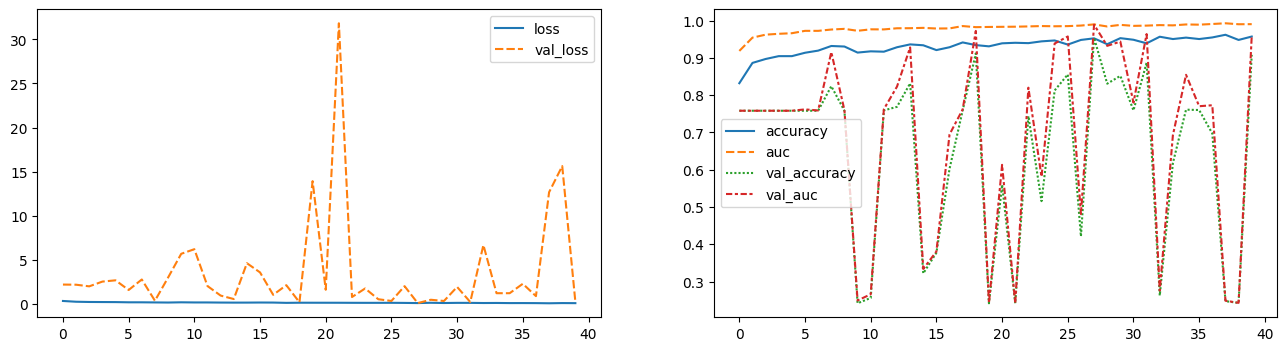

2024-05-29 22:22:52.854555: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ShallowCNNM.ckpt: FAILED_PRECONDITION: models/ShallowCNNM.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



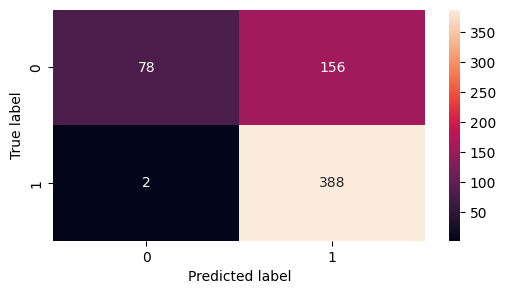


              precision    recall  f1-score   support

           0       0.97      0.33      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.71       624



epoch/accuracy,▁▄▄▅▅▅▆▆▆▅▆▆▆▇▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█▇█▇██▇█
epoch/auc,▁▄▅▅▅▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▃▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁
epoch/val_accuracy,▆▆▆▆▆▆▆▇▆▁▁▆▆▇▂▂▅▆█▁▄▁▆▄▇▇▃█▇▇▆▇▁▅▆▆▅▁▁█
epoch/val_auc,▆▆▆▆▆▆▆▇▆▁▁▆▆▇▂▂▅▆█▁▄▁▆▄██▃█▇█▆█▁▅▇▆▆▁▁█
epoch/val_loss,▁▁▁▂▂▁▂▁▂▂▂▁▁▁▂▂▁▁▁▄▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▄▄▁
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [65]:
size_indicator="M"
# size_indicator="S"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ShallowCNN(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

4185.0
=== MODEL EVALUATION =================================================

Model: "ShallowCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 norm_1 (BatchNormalization  (None, 224, 224, 64)      256       
 )                                                               
                                                                 
 actv_1 (Activation)         (None, 224, 224, 64)      0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 64)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 11


--- Model training ---------------------------------------------------

Epoch 1/40


  6/131 [>.............................] - ETA: 10s - loss: 0.5743 - accuracy: 0.7083 - auc: 0.7854WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0489s vs `on_train_batch_end` time: 0.0512s). Check your callbacks.


131/131 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8679 - auc: 0.9455
Epoch 1: val_auc improved from -inf to 0.75799, saving model to ./models/ShallowCNNL.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 19s 102ms/step - loss: 0.2982 - accuracy: 0.8679 - auc: 0.9455 - val_loss: 1.5124 - val_accuracy: 0.7584 - val_auc: 0.7580
Epoch 2/40
131/131 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9027 - auc: 0.9665
Epoch 2: val_auc improved from 0.75799 to 0.75836, saving model to ./models/ShallowCNNL.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 10s 77ms/step - loss: 0.2363 - accuracy: 0.9027 - auc: 0.9665 - val_loss: 3.2561 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 3/40
131/131 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9204 - auc: 0.9751
Epoch 3: val_auc improved from 0.75836 to 0.76705, saving model to ./models/ShallowCNNL.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 9s 68ms/step - loss: 0.2010 - accuracy: 0.9204 - auc: 0.9751 - val_loss: 1.7665 - val_accuracy: 0.7584 - val_auc: 0.7670
Epoch 4/40
131/131 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9180 - auc: 0.9758
Epoch 4: val_auc improved from 0.76705 to 0.79343, saving model to ./models/ShallowCNNL.ckpt
INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 9s 71ms/step - loss: 0.2000 - accuracy: 0.9180 - auc: 0.9758 - val_loss: 1.4496 - val_accuracy: 0.7593 - val_auc: 0.7934
Epoch 5/40
131/131 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9262 - auc: 0.9786
Epoch 5: val_auc did not improve from 0.79343
131/131 [==============================] - 7s 53ms/step - loss: 0.1862 - accuracy: 0.9262 - auc: 0.9786 - val_loss: 2.9227 - val_accuracy: 0.2951 - val_auc: 0.4005
Epoch 6/40
130/131 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9376 - auc: 0.9812
Epoch 6: val_auc did not improve from 0.79343
131/131 [==============================] - 7s 53ms/step - loss: 0.1724 - accuracy: 0.9376 - auc: 0.9812 - val_loss: 8.7638 - val_accuracy: 0.2416 - val_auc: 0.2435
Epoch 7/40
130/131 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9311 - auc: 0.9788
Epoch 7: val_auc did not improve from 0.79343
131/131 [==============================]

INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 8s 64ms/step - loss: 0.1784 - accuracy: 0.9348 - auc: 0.9802 - val_loss: 0.1863 - val_accuracy: 0.9341 - val_auc: 0.9804
Epoch 9/40
131/131 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9802
Epoch 9: val_auc did not improve from 0.98039
131/131 [==============================] - 7s 53ms/step - loss: 0.1777 - accuracy: 0.9326 - auc: 0.9802 - val_loss: 17.9219 - val_accuracy: 0.2416 - val_auc: 0.2428
Epoch 10/40
131/131 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9386 - auc: 0.9840
Epoch 10: val_auc did not improve from 0.98039
131/131 [==============================] - 7s 53ms/step - loss: 0.1599 - accuracy: 0.9386 - auc: 0.9840 - val_loss: 0.8562 - val_accuracy: 0.7631 - val_auc: 0.8724
Epoch 11/40
131/131 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9407 - auc: 0.9846
Epoch 11: val_auc did not improve from 0.98039
131/131 [==========================

INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 8s 64ms/step - loss: 0.1160 - accuracy: 0.9517 - auc: 0.9912 - val_loss: 0.1670 - val_accuracy: 0.9312 - val_auc: 0.9837
Epoch 29/40
131/131 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9548 - auc: 0.9900
Epoch 29: val_auc did not improve from 0.98371
131/131 [==============================] - 7s 53ms/step - loss: 0.1247 - accuracy: 0.9548 - auc: 0.9900 - val_loss: 0.8405 - val_accuracy: 0.7880 - val_auc: 0.8969
Epoch 30/40
131/131 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9558 - auc: 0.9916
Epoch 30: val_auc did not improve from 0.98371
131/131 [==============================] - 7s 53ms/step - loss: 0.1145 - accuracy: 0.9558 - auc: 0.9916 - val_loss: 4.6831 - val_accuracy: 0.3209 - val_auc: 0.3345
Epoch 31/40
131/131 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9615 - auc: 0.9920
Epoch 31: val_auc did not improve from 0.98371
131/131 [=========================

INFO:tensorflow:Assets written to: ./models/ShallowCNNL.ckpt/assets


131/131 [==============================] - 9s 65ms/step - loss: 0.0813 - accuracy: 0.9689 - auc: 0.9955 - val_loss: 0.1527 - val_accuracy: 0.9341 - val_auc: 0.9854
Epoch 40/40
131/131 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9670 - auc: 0.9950
Epoch 40: val_auc did not improve from 0.98537
131/131 [==============================] - 7s 53ms/step - loss: 0.0855 - accuracy: 0.9670 - auc: 0.9950 - val_loss: 3.0881 - val_accuracy: 0.3992 - val_auc: 0.4107

--- Training history -------------------------------------------------



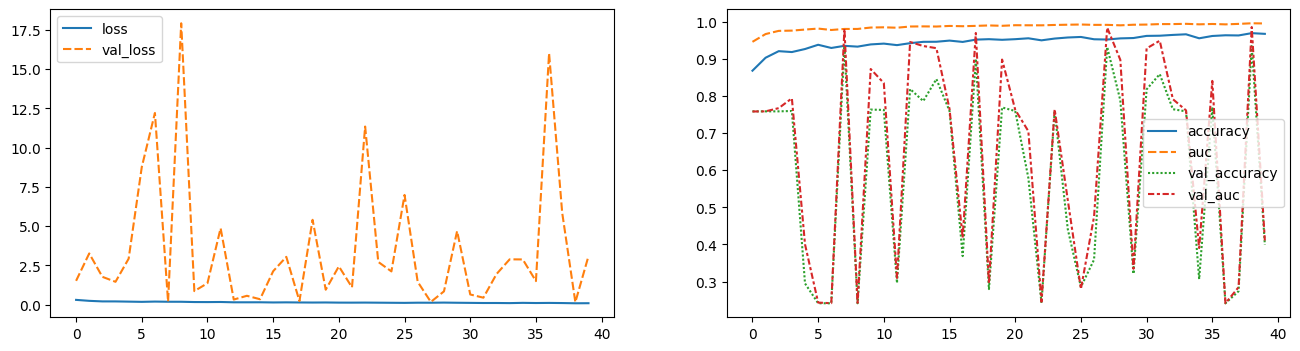

2024-05-29 22:30:46.367880: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ShallowCNNL.ckpt: FAILED_PRECONDITION: models/ShallowCNNL.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



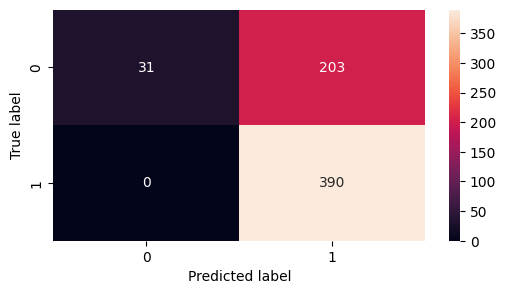


              precision    recall  f1-score   support

           0       1.00      0.13      0.23       234
           1       0.66      1.00      0.79       390

    accuracy                           0.67       624
   macro avg       0.83      0.57      0.51       624
weighted avg       0.79      0.67      0.58       624



epoch/accuracy,▁▃▅▄▅▆▅▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇████
epoch/auc,▁▄▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁
epoch/val_accuracy,▆▆▆▆▂▁▁█▁▆▆▂▇▇▇▆▂█▁▆▆▄▁▆▃▁▂█▇▂▇▇▆▆▂▆▁▁█▃
epoch/val_auc,▆▆▆▆▂▁▁█▁▇▇▂██▇▆▃█▂▇▆▅▁▆▄▁▃█▇▂▇█▆▆▂▇▁▁█▃
epoch/val_loss,▂▂▂▂▂▄▆▁█▁▁▃▁▁▁▂▂▁▃▁▂▁▅▂▂▄▂▁▁▃▁▁▂▂▂▂▇▃▁▂
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [66]:
size_indicator="L"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ShallowCNN(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

In [ ]:
# evaluate_model(create_model_ResNet50(x_train.shape, 2), forced_training=True)

## ResNet50

In [67]:
def create_model_ResNet50(X_shape, classes=2, name="ResNet50"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    def conv_block(x, *, filters, kernel_size, strides=(1, 1), padding='same', activation='relu', name=""):
        x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, name=f"{name}_conv")(x)
        x = layers.BatchNormalization(name=f"{name}_norm")(x)
        if activation:
            x = layers.Activation(activation, name=f"{name}_actn")(x)
        return x

    def identity_block(x, *, filters, name=""):
        shortcut = x
        x = conv_block(x, filters=filters, kernel_size=(1, 1), name=f"{name}_cb1")
        x = conv_block(x, filters=filters, kernel_size=(3, 3), name=f"{name}_cb2")
        x = conv_block(x, filters=filters * 4, kernel_size=(1, 1), activation='', name=f"{name}_cb3")
        x = layers.Add(name=f"{name}_add")([x, shortcut])
        x = layers.Activation('relu', name=f"{name}_actn")(x)
        return x

    def projection_block(x, *, filters, strides, name=""):
        shortcut = x
        x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides, name=f"{name}_cb1")
        x = conv_block(x, filters=filters, kernel_size=(3, 3), name=f"{name}_cb2")
        x = conv_block(x, filters=filters * 4, kernel_size=(1, 1), activation='', name=f"{name}_cb3")
        shortcut = conv_block(shortcut, filters=filters * 4, kernel_size=(1, 1), strides=strides, activation='', name=f"{name}_cb4")
        x = layers.Add(name=f"{name}_add")([x, shortcut])
        x = layers.Activation('relu', name=f"{name}_actn")(x)
        return x

    inputs = Input(X_shape[-3:], name='inputs')

    # === Stage 1 ===
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', name="stg1_cb1")
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="stg1_maxpool")(x)

    # === Stage 2 ===
    x = projection_block(x, filters=64, strides=(1, 1), name="stg2_pb")
    x = identity_block(x, filters=64, name="stg2_ib1")
    x = identity_block(x, filters=64, name="stg2_ib2")

    # === Stage 3 ===
    x = projection_block(x, filters=128, strides=(2, 2), name="stg3_pb")
    x = identity_block(x, filters=128, name="stg3_ib1")
    x = identity_block(x, filters=128, name="stg3_ib2")
    x = identity_block(x, filters=128, name="stg3_ib3")

    # === Stage 4 ===
    x = projection_block(x, filters=256, strides=(2, 2), name="stg4_pb")
    x = identity_block(x, filters=256, name="stg4_ib1")
    x = identity_block(x, filters=256, name="stg4_ib2")
    x = identity_block(x, filters=256, name="stg4_ib3")
    x = identity_block(x, filters=256, name="stg4_ib4")
    x = identity_block(x, filters=256, name="stg4_ib5")

    # === Stage 5 ===
    x = projection_block(x, filters=512, strides=(2, 2), name="stg5_pb")
    x = identity_block(x, filters=512, name="stg5_ib1")
    x = identity_block(x, filters=512, name="stg5_ib2")

    x = layers.GlobalAveragePooling2D(name=f"stg5_globaver")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

input_shape = (224, 224, 3)
create_model_ResNet50(input_shape, classes=2).summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stg1_cb1_conv (Conv2D)      (None, 112, 112, 64)         9472      ['inputs[0][0]']              
                                                                                                  
 stg1_cb1_norm (BatchNormal  (None, 112, 112, 64)         256       ['stg1_cb1_conv[0][0]']       
 ization)                                                                                         
                                                                                                  
 stg1_cb1_actn (Activation)  (None, 112, 112, 64)         0         ['stg1_cb1_norm[0][0]']

523.125
=== MODEL EVALUATION =================================================

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 stg1_cb1_conv (Conv2D)      (None, 112, 112, 64)         3200      ['inputs[0][0]']              
                                                                                                  
 stg1_cb1_norm (BatchNormal  (None, 112, 112, 64)         256       ['stg1_cb1_conv[0][0]']       
 ization)                                                                                         
                                                                                                  
 stg1_cb1_a


--- Model training ---------------------------------------------------

Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.6788 - auc: 0.7370
Epoch 1: val_auc improved from -inf to 0.76285, saving model to ./models/ResNet50T.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


17/17 [==============================] - 57s 2s/step - loss: 1.6888 - accuracy: 0.6788 - auc: 0.7370 - val_loss: 0.5986 - val_accuracy: 0.7584 - val_auc: 0.7628
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8566 - auc: 0.9305
Epoch 2: val_auc did not improve from 0.76285
17/17 [==============================] - 7s 416ms/step - loss: 0.4335 - accuracy: 0.8566 - auc: 0.9305 - val_loss: 7.9532 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8757 - auc: 0.9293
Epoch 3: val_auc did not improve from 0.76285
17/17 [==============================] - 7s 409ms/step - loss: 0.4338 - accuracy: 0.8757 - auc: 0.9293 - val_loss: 2.4015 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/40
17/17 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8929 - auc: 0.9569
Epoch 4: val_auc did not improve from 0.76285
17/17 [==============================] - 7s 410ms/s

INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


17/17 [==============================] - 30s 2s/step - loss: 0.1129 - accuracy: 0.9560 - auc: 0.9906 - val_loss: 1.4928 - val_accuracy: 0.7698 - val_auc: 0.8208
Epoch 22/40
17/17 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9522 - auc: 0.9873
Epoch 22: val_auc did not improve from 0.82081
17/17 [==============================] - 7s 419ms/step - loss: 0.1404 - accuracy: 0.9522 - auc: 0.9873 - val_loss: 1.2708 - val_accuracy: 0.6877 - val_auc: 0.7325
Epoch 23/40
16/17 [===========================>..] - ETA: 0s - loss: 0.0645 - accuracy: 0.9785 - auc: 0.9963
Epoch 23: val_auc improved from 0.82081 to 0.82965, saving model to ./models/ResNet50T.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


17/17 [==============================] - 23s 1s/step - loss: 0.0730 - accuracy: 0.9771 - auc: 0.9958 - val_loss: 1.8810 - val_accuracy: 0.7851 - val_auc: 0.8296
Epoch 24/40
17/17 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9235 - auc: 0.9780
Epoch 24: val_auc did not improve from 0.82965
17/17 [==============================] - 7s 410ms/step - loss: 0.1931 - accuracy: 0.9235 - auc: 0.9780 - val_loss: 4.3520 - val_accuracy: 0.2416 - val_auc: 0.3246
Epoch 25/40
17/17 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9560 - auc: 0.9916
Epoch 25: val_auc did not improve from 0.82965
17/17 [==============================] - 7s 424ms/step - loss: 0.1164 - accuracy: 0.9560 - auc: 0.9916 - val_loss: 1.7509 - val_accuracy: 0.6122 - val_auc: 0.5988
Epoch 26/40
17/17 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9809 - auc: 0.9972
Epoch 26: val_auc improved from 0.82965 to 0.95848, saving model to ./models/ResNet50T.ckpt


INFO:tensorflow:Assets written to: ./models/ResNet50T.ckpt/assets


17/17 [==============================] - 25s 2s/step - loss: 0.0695 - accuracy: 0.9809 - auc: 0.9972 - val_loss: 0.3178 - val_accuracy: 0.8883 - val_auc: 0.9585
Epoch 27/40
17/17 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9847 - auc: 0.9972
Epoch 27: val_auc did not improve from 0.95848
17/17 [==============================] - 7s 407ms/step - loss: 0.0451 - accuracy: 0.9847 - auc: 0.9972 - val_loss: 1.6822 - val_accuracy: 0.4947 - val_auc: 0.5454
Epoch 28/40
17/17 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9962 - auc: 1.0000
Epoch 28: val_auc did not improve from 0.95848
17/17 [==============================] - 7s 406ms/step - loss: 0.0123 - accuracy: 0.9962 - auc: 1.0000 - val_loss: 6.0812 - val_accuracy: 0.2856 - val_auc: 0.3070
Epoch 29/40
17/17 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9962 - auc: 0.9999
Epoch 29: val_auc did not improve from 0.95848
17/17 [==============================] - 7s 4

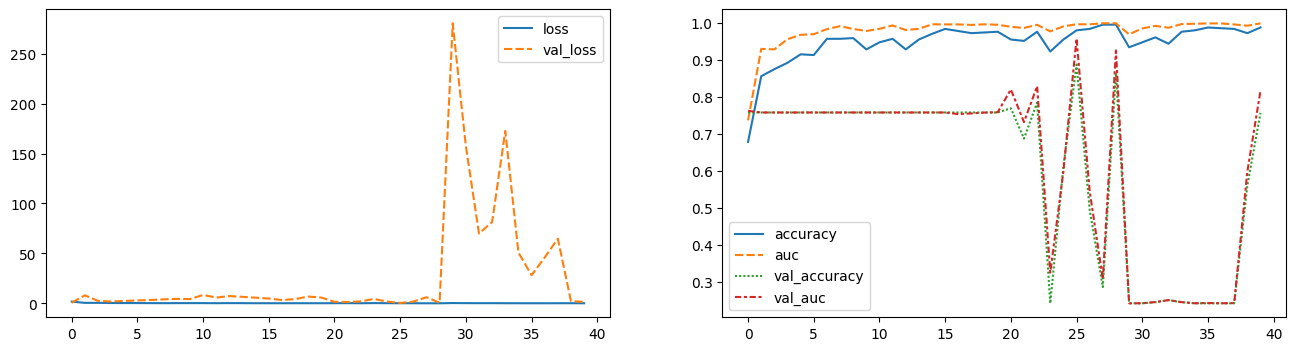

2024-05-29 22:56:22.561117: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ResNet50T.ckpt: FAILED_PRECONDITION: models/ResNet50T.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



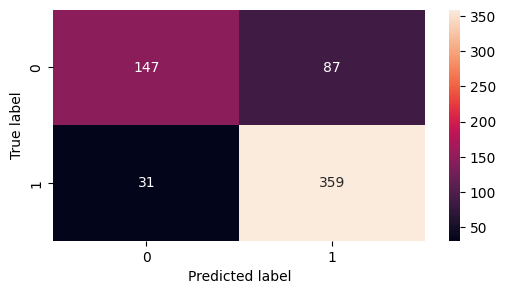


              precision    recall  f1-score   support

           0       0.83      0.63      0.71       234
           1       0.80      0.92      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.77      0.79       624
weighted avg       0.81      0.81      0.80       624



epoch/accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇██▇▇█▆▇████▇▇▇▇█████▇█
epoch/auc,▁▆▆▇▇▇███▇█████████████▇█████▇██████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁
epoch/val_accuracy,▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▁▅█▄▁█▁▁▁▁▁▁▁▁▁▄▇
epoch/val_auc,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▂▄█▄▂█▁▁▁▁▁▁▁▁▁▄▇
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▃▃▅▂▂▂▃▁▁
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [72]:
size_indicator="T"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

1046.25
=== MODEL EVALUATION =================================================

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 stg1_cb1_conv (Conv2D)      (None, 112, 112, 64)         3200      ['inputs[0][0]']              
                                                                                                  
 stg1_cb1_norm (BatchNormal  (None, 112, 112, 64)         256       ['stg1_cb1_conv[0][0]']       
 ization)                                                                                         
                                                                                                  
 stg1_cb1_a


--- Model training ---------------------------------------------------

Epoch 1/40


 6/33 [====>.........................] - ETA: 2s - loss: 1.4671 - accuracy: 0.7708 - auc: 0.7794WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0655s vs `on_train_batch_end` time: 0.2814s). Check your callbacks.


33/33 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.7973 - auc: 0.8581
Epoch 1: val_auc improved from -inf to 0.75836, saving model to ./models/ResNet50S.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


33/33 [==============================] - 51s 960ms/step - loss: 0.8161 - accuracy: 0.7973 - auc: 0.8581 - val_loss: 5.4728 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 2/40
33/33 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8872 - auc: 0.9441
Epoch 2: val_auc improved from 0.75836 to 0.75859, saving model to ./models/ResNet50S.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


33/33 [==============================] - 25s 775ms/step - loss: 0.3547 - accuracy: 0.8872 - auc: 0.9441 - val_loss: 1.2224 - val_accuracy: 0.7584 - val_auc: 0.7586
Epoch 3/40
33/33 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8920 - auc: 0.9518
Epoch 3: val_auc did not improve from 0.75859
33/33 [==============================] - 8s 259ms/step - loss: 0.3162 - accuracy: 0.8920 - auc: 0.9518 - val_loss: 2.5815 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/40
33/33 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9111 - auc: 0.9649
Epoch 4: val_auc did not improve from 0.75859
33/33 [==============================] - 9s 268ms/step - loss: 0.2535 - accuracy: 0.9111 - auc: 0.9649 - val_loss: 3.9884 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 5/40
33/33 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9398 - auc: 0.9852
Epoch 5: val_auc did not improve from 0.75859
33/33 [==============================] - 8s 261m

INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


33/33 [==============================] - 28s 883ms/step - loss: 0.0782 - accuracy: 0.9723 - auc: 0.9951 - val_loss: 1.4068 - val_accuracy: 0.7268 - val_auc: 0.8018
Epoch 12/40
33/33 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9608 - auc: 0.9895
Epoch 12: val_auc did not improve from 0.80184
33/33 [==============================] - 9s 271ms/step - loss: 0.1200 - accuracy: 0.9608 - auc: 0.9895 - val_loss: 1.5119 - val_accuracy: 0.7584 - val_auc: 0.7852
Epoch 13/40
33/33 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9637 - auc: 0.9937
Epoch 13: val_auc improved from 0.80184 to 0.92256, saving model to ./models/ResNet50S.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50S.ckpt/assets


33/33 [==============================] - 27s 852ms/step - loss: 0.0979 - accuracy: 0.9637 - auc: 0.9937 - val_loss: 0.5514 - val_accuracy: 0.7861 - val_auc: 0.9226
Epoch 14/40
33/33 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9771 - auc: 0.9976
Epoch 14: val_auc did not improve from 0.92256
33/33 [==============================] - 8s 252ms/step - loss: 0.0650 - accuracy: 0.9771 - auc: 0.9976 - val_loss: 3.1829 - val_accuracy: 0.7526 - val_auc: 0.7537
Epoch 15/40
33/33 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9876 - auc: 0.9984
Epoch 15: val_auc did not improve from 0.92256
33/33 [==============================] - 8s 254ms/step - loss: 0.0348 - accuracy: 0.9876 - auc: 0.9984 - val_loss: 1.4522 - val_accuracy: 0.7488 - val_auc: 0.7767
Epoch 16/40
33/33 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9914 - auc: 0.9974
Epoch 16: val_auc did not improve from 0.92256
33/33 [==============================] - 8

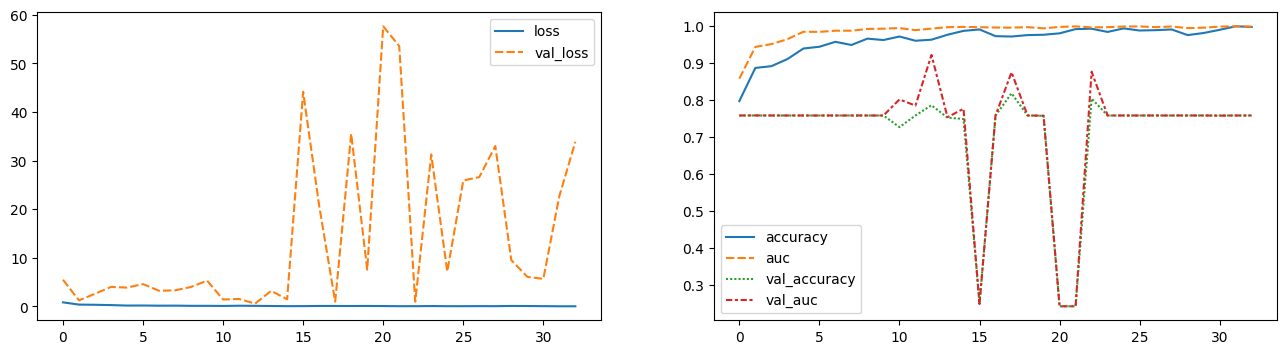

2024-05-29 23:05:52.253722: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ResNet50S.ckpt: FAILED_PRECONDITION: models/ResNet50S.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



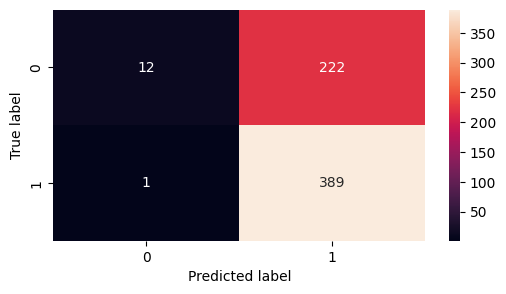


              precision    recall  f1-score   support

           0       0.92      0.05      0.10       234
           1       0.64      1.00      0.78       390

    accuracy                           0.64       624
   macro avg       0.78      0.52      0.44       624
weighted avg       0.74      0.64      0.52       624



epoch/accuracy,▁▄▄▅▆▆▇▆▇▇▇▇▇▇██▇▇▇▇▇██▇████▇▇███
epoch/auc,▁▅▆▆▇▇▇▇███▇█████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch/val_accuracy,▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▁▇█▇▇▁▁█▇▇▇▇▇▇▇▇▇▇
epoch/val_auc,▆▆▆▆▆▆▆▆▆▆▇▇█▆▇▁▆█▆▆▁▁█▆▆▆▆▆▆▆▆▆▆
epoch/val_loss,▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▆▃▁▅▂█▇▁▅▂▄▄▅▂▂▂▄▅
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [73]:
size_indicator="S"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

2092.5
=== MODEL EVALUATION =================================================

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 stg1_cb1_conv (Conv2D)      (None, 112, 112, 64)         3200      ['inputs[0][0]']              
                                                                                                  
 stg1_cb1_norm (BatchNormal  (None, 112, 112, 64)         256       ['stg1_cb1_conv[0][0]']       
 ization)                                                                                         
                                                                                                  
 stg1_cb1_ac


--- Model training ---------------------------------------------------

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.8265 - auc: 0.8979
Epoch 1: val_auc improved from -inf to 0.75836, saving model to ./models/ResNet50M.ckpt


INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


66/66 [==============================] - 56s 508ms/step - loss: 0.6672 - accuracy: 0.8265 - auc: 0.8979 - val_loss: 3.7345 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9001 - auc: 0.9605
Epoch 2: val_auc improved from 0.75836 to 0.77695, saving model to ./models/ResNet50M.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


66/66 [==============================] - 29s 436ms/step - loss: 0.2708 - accuracy: 0.9001 - auc: 0.9605 - val_loss: 1.3776 - val_accuracy: 0.7584 - val_auc: 0.7769
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9359 - auc: 0.9811
Epoch 3: val_auc did not improve from 0.77695
66/66 [==============================] - 12s 177ms/step - loss: 0.1747 - accuracy: 0.9359 - auc: 0.9811 - val_loss: 3.9628 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 4/40
66/66 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9436 - auc: 0.9844
Epoch 4: val_auc did not improve from 0.77695
66/66 [==============================] - 11s 175ms/step - loss: 0.1581 - accuracy: 0.9436 - auc: 0.9844 - val_loss: 3.6821 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 5/40
66/66 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9608 - auc: 0.9900
Epoch 5: val_auc improved from 0.77695 to 0.83524, saving model to ./models/ResNet50M.ckpt
I

INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


66/66 [==============================] - 32s 493ms/step - loss: 0.1171 - accuracy: 0.9608 - auc: 0.9900 - val_loss: 1.5538 - val_accuracy: 0.7584 - val_auc: 0.8352
Epoch 6/40
66/66 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9627 - auc: 0.9922
Epoch 6: val_auc improved from 0.83524 to 0.92962, saving model to ./models/ResNet50M.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50M.ckpt/assets


66/66 [==============================] - 30s 456ms/step - loss: 0.1013 - accuracy: 0.9627 - auc: 0.9922 - val_loss: 0.5442 - val_accuracy: 0.8290 - val_auc: 0.9296
Epoch 7/40
66/66 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9551 - auc: 0.9905
Epoch 7: val_auc did not improve from 0.92962
66/66 [==============================] - 12s 180ms/step - loss: 0.1222 - accuracy: 0.9551 - auc: 0.9905 - val_loss: 2.1766 - val_accuracy: 0.6380 - val_auc: 0.6299
Epoch 8/40
66/66 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9646 - auc: 0.9956
Epoch 8: val_auc did not improve from 0.92962
66/66 [==============================] - 12s 180ms/step - loss: 0.0829 - accuracy: 0.9646 - auc: 0.9956 - val_loss: 16.4123 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 9/40
66/66 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9665 - auc: 0.9917
Epoch 9: val_auc did not improve from 0.92962
66/66 [==============================] - 12s 

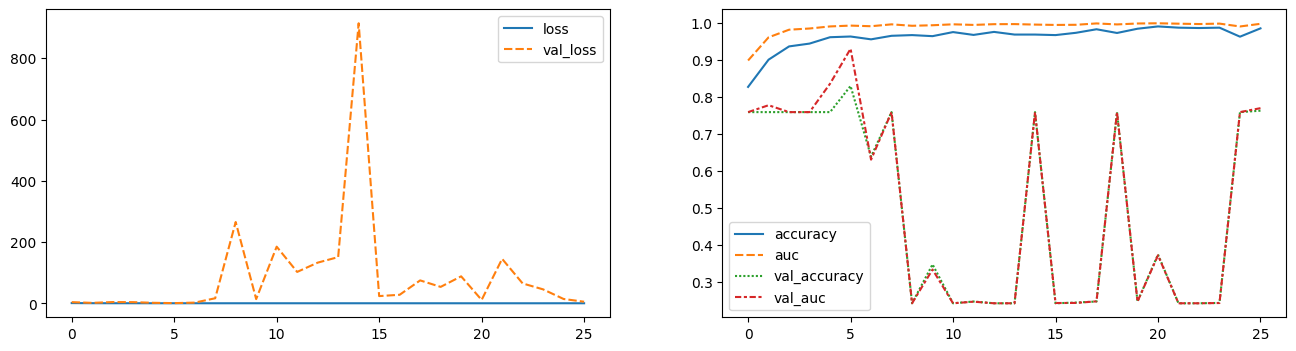

2024-05-29 23:17:20.811140: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ResNet50M.ckpt: FAILED_PRECONDITION: models/ResNet50M.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



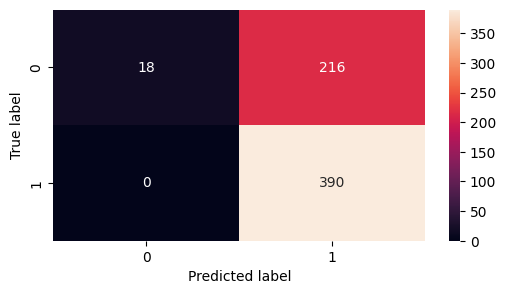


              precision    recall  f1-score   support

           0       1.00      0.08      0.14       234
           1       0.64      1.00      0.78       390

    accuracy                           0.65       624
   macro avg       0.82      0.54      0.46       624
weighted avg       0.78      0.65      0.54       624



epoch/accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████▇█
epoch/auc,▁▅▇▇▇█▇█████████████████▇█
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▂▁
epoch/val_accuracy,▇▇▇▇▇█▆▇▁▂▁▁▁▁▇▁▁▁▇▁▃▁▁▁▇▇
epoch/val_auc,▆▆▆▆▇█▅▆▁▂▁▁▁▁▆▁▁▁▆▁▂▁▁▁▆▆
epoch/val_loss,▁▁▁▁▁▁▁▁▃▁▂▂▂▂█▁▁▂▁▂▁▂▁▁▁▁
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [74]:
size_indicator="M"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

4185.0
=== MODEL EVALUATION =================================================

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 stg1_cb1_conv (Conv2D)      (None, 112, 112, 64)         3200      ['inputs[0][0]']              
                                                                                                  
 stg1_cb1_norm (BatchNormal  (None, 112, 112, 64)         256       ['stg1_cb1_conv[0][0]']       
 ization)                                                                                         
                                                                                                  
 stg1_cb1_ac


--- Model training ---------------------------------------------------

Epoch 1/40


  6/131 [>.............................] - ETA: 12s - loss: 2.8349 - accuracy: 0.6875 - auc: 0.7237WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0635s vs `on_train_batch_end` time: 0.0742s). Check your callbacks.


131/131 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.8225 - auc: 0.9039
Epoch 1: val_auc improved from -inf to 0.75836, saving model to ./models/ResNet50L.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 67s 339ms/step - loss: 0.5540 - accuracy: 0.8225 - auc: 0.9039 - val_loss: 5.7317 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 2/40
131/131 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9329 - auc: 0.9785
Epoch 2: val_auc did not improve from 0.75836
131/131 [==============================] - 22s 165ms/step - loss: 0.1884 - accuracy: 0.9329 - auc: 0.9785 - val_loss: 4.5425 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 3/40
131/131 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9455 - auc: 0.9872
Epoch 3: val_auc did not improve from 0.75836
131/131 [==============================] - 22s 166ms/step - loss: 0.1413 - accuracy: 0.9455 - auc: 0.9872 - val_loss: 4.3572 - val_accuracy: 0.7479 - val_auc: 0.7479
Epoch 4/40
131/131 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9558 - auc: 0.9899
Epoch 4: val_auc did not improve from 0.75836
131/131 [=========================

INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 41s 312ms/step - loss: 0.0924 - accuracy: 0.9663 - auc: 0.9938 - val_loss: 1.8919 - val_accuracy: 0.7603 - val_auc: 0.7697
Epoch 11/40
131/131 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9742 - auc: 0.9966
Epoch 11: val_auc did not improve from 0.76973
131/131 [==============================] - 19s 147ms/step - loss: 0.0697 - accuracy: 0.9742 - auc: 0.9966 - val_loss: 9.8304 - val_accuracy: 0.7564 - val_auc: 0.7562
Epoch 12/40
131/131 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9711 - auc: 0.9954
Epoch 12: val_auc did not improve from 0.76973
131/131 [==============================] - 19s 146ms/step - loss: 0.0790 - accuracy: 0.9711 - auc: 0.9954 - val_loss: 35.7750 - val_accuracy: 0.2436 - val_auc: 0.2436
Epoch 13/40
131/131 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9771 - auc: 0.9970
Epoch 13: val_auc did not improve from 0.76973
131/131 [==================

INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 38s 294ms/step - loss: 0.0853 - accuracy: 0.9723 - auc: 0.9950 - val_loss: 0.6098 - val_accuracy: 0.7335 - val_auc: 0.7717
Epoch 15/40
131/131 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9728 - auc: 0.9972
Epoch 15: val_auc did not improve from 0.77168
131/131 [==============================] - 19s 144ms/step - loss: 0.0655 - accuracy: 0.9728 - auc: 0.9972 - val_loss: 2.7521 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 16/40
131/131 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9802 - auc: 0.9974
Epoch 16: val_auc did not improve from 0.77168
131/131 [==============================] - 19s 146ms/step - loss: 0.0578 - accuracy: 0.9802 - auc: 0.9974 - val_loss: 16.6982 - val_accuracy: 0.2502 - val_auc: 0.2471
Epoch 17/40
131/131 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9780 - auc: 0.9957
Epoch 17: val_auc did not improve from 0.77168
131/131 [==================

INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 39s 300ms/step - loss: 0.0401 - accuracy: 0.9869 - auc: 0.9978 - val_loss: 2.2326 - val_accuracy: 0.7593 - val_auc: 0.7740
Epoch 27/40
131/131 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9847 - auc: 0.9982
Epoch 27: val_auc did not improve from 0.77400
131/131 [==============================] - 18s 135ms/step - loss: 0.0443 - accuracy: 0.9847 - auc: 0.9982 - val_loss: 4.1641 - val_accuracy: 0.7584 - val_auc: 0.7584
Epoch 28/40
131/131 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9835 - auc: 0.9987
Epoch 28: val_auc improved from 0.77400 to 0.78363, saving model to ./models/ResNet50L.ckpt
INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 38s 290ms/step - loss: 0.0425 - accuracy: 0.9835 - auc: 0.9987 - val_loss: 1.0984 - val_accuracy: 0.7593 - val_auc: 0.7836
Epoch 29/40
131/131 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9907 - auc: 0.9993
Epoch 29: val_auc did not improve from 0.78363
131/131 [==============================] - 18s 136ms/step - loss: 0.0279 - accuracy: 0.9907 - auc: 0.9993 - val_loss: 1.6027 - val_accuracy: 0.7584 - val_auc: 0.7424
Epoch 30/40
131/131 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9928 - auc: 0.9995
Epoch 30: val_auc did not improve from 0.78363
131/131 [==============================] - 18s 137ms/step - loss: 0.0215 - accuracy: 0.9928 - auc: 0.9995 - val_loss: 1.8280 - val_accuracy: 0.6428 - val_auc: 0.6866
Epoch 31/40
131/131 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9869 - auc: 0.9984
Epoch 31: val_auc did not improve from 0.78363
131/131 [===================

INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 38s 293ms/step - loss: 0.0213 - accuracy: 0.9924 - auc: 0.9995 - val_loss: 0.7008 - val_accuracy: 0.8367 - val_auc: 0.9184
Epoch 33/40
131/131 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9873 - auc: 0.9980
Epoch 33: val_auc did not improve from 0.91844
131/131 [==============================] - 18s 139ms/step - loss: 0.0471 - accuracy: 0.9873 - auc: 0.9980 - val_loss: 4.1561 - val_accuracy: 0.5186 - val_auc: 0.5097
Epoch 34/40
131/131 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9838 - auc: 0.9979
Epoch 34: val_auc did not improve from 0.91844
131/131 [==============================] - 18s 139ms/step - loss: 0.0508 - accuracy: 0.9838 - auc: 0.9979 - val_loss: 1.8989 - val_accuracy: 0.7612 - val_auc: 0.7924
Epoch 35/40
131/131 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9883 - auc: 0.9990
Epoch 35: val_auc did not improve from 0.91844
131/131 [===================

INFO:tensorflow:Assets written to: ./models/ResNet50L.ckpt/assets


131/131 [==============================] - 43s 332ms/step - loss: 0.0390 - accuracy: 0.9873 - auc: 0.9981 - val_loss: 0.4283 - val_accuracy: 0.8787 - val_auc: 0.9522
Epoch 37/40
131/131 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9907 - auc: 0.9982
Epoch 37: val_auc did not improve from 0.95218
131/131 [==============================] - 18s 139ms/step - loss: 0.0351 - accuracy: 0.9907 - auc: 0.9982 - val_loss: 0.6287 - val_accuracy: 0.7956 - val_auc: 0.8754
Epoch 38/40
131/131 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9902 - auc: 0.9991
Epoch 38: val_auc did not improve from 0.95218
131/131 [==============================] - 18s 139ms/step - loss: 0.0328 - accuracy: 0.9902 - auc: 0.9991 - val_loss: 0.4385 - val_accuracy: 0.8309 - val_auc: 0.9069
Epoch 39/40
131/131 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9890 - auc: 0.9988
Epoch 39: val_auc did not improve from 0.95218
131/131 [===================

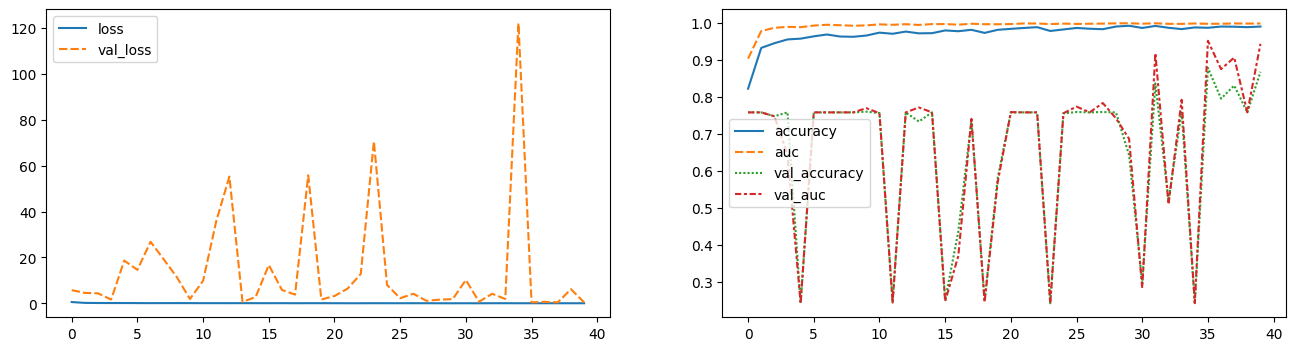

2024-05-29 23:36:45.514052: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./models/ResNet50L.ckpt: FAILED_PRECONDITION: models/ResNet50L.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



--- Test Predictions and Metrics -------------------------------------



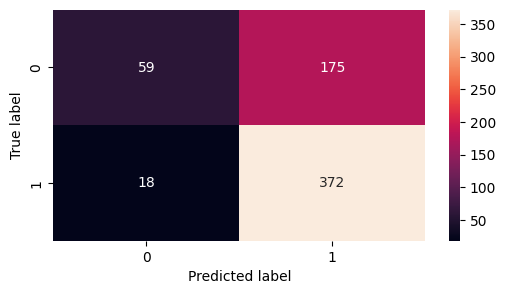


              precision    recall  f1-score   support

           0       0.77      0.25      0.38       234
           1       0.68      0.95      0.79       390

    accuracy                           0.69       624
   macro avg       0.72      0.60      0.59       624
weighted avg       0.71      0.69      0.64       624



epoch/accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████▇████████████████
epoch/auc,▁▆▇▇▇███████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▇▇▇▇▁▇▇▇▇▇▇▁▇▆▇▁▃▆▁▅▇▇▇▁▇▇▇▇▇▅▂█▄▇▁█▇▇▇█
epoch/val_auc,▆▆▆▅▁▆▆▆▆▆▆▁▆▆▆▁▂▆▁▄▆▆▆▁▆▆▆▆▆▅▁█▄▆▁█▇█▆█
epoch/val_loss,▁▁▁▁▂▂▃▂▂▁▂▃▄▁▁▂▁▁▄▁▁▁▂▅▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁
test_accuracy,▁
test_samples,▁
training_samples,▁



=== MODEL EVALUATION FINISHED ========================================


In [75]:
size_indicator="L"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50(x_train.shape, 2), x_train, x_valid, x_test, y_train, y_valid, y_test, datagen, forced_training=True, name_suffix=size_indicator)

## Pre trained ResNet50

In [ ]:
from keras.applications import ResNet50

def create_model_ResNet50Trans(X_shape, classes=2, name="ResNet50Trans"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    base_model = ResNet50(include_top=False, input_shape=tuple(X_shape)[-3:])
    base_model.trainable = False

    inputs = Input(X_shape[-3:], name='inputs')

    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D(name=f"global_average")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

In [ ]:
size_indicator="L"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50Trans(x_train.shape, 2), forced_training=True, size_indicator=size_indicator)

## RGB data

In [1]:
# Prepare RGB data because of pretrained architecture

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(*get_datasource(DATA_TRAIN, DATA_VALID, flag=cv2.IMREAD_COLOR), test_size=0.2)
size_indicator="L"
x_train, x_valid, y_train, y_valid = make_dataset_smaller(x_train_orig, x_valid_orig, y_train_orig, y_valid_orig, size_indicator=size_indicator)
x_test, y_test = get_datasource(DATA_TEST, flag=cv2.IMREAD_COLOR)

datagen = ImageDataGenerator(
#         rotation_range = 30,
#         zoom_range = 0.2,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip = True,
        vertical_flip=False
)

datagen.fit(x_train)

NameError: name 'train_test_split' is not defined

In [ ]:
# y_train, y_valid = y_train_rgb, y_valid_rgb

In [ ]:
x_train_orig.shape

In [ ]:
size_indicator="T"
x_train, x_valid = make_dataset_smaller(x_train_orig, x_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50Trans(x_train.shape, 2), forced_training=True, size_indicator=size_indicator)

In [ ]:
size_indicator="S""
x_train, x_valid = make_dataset_smaller(x_train_orig, x_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50Trans(x_train.shape, 2), forced_training=True, size_indicator=size_indicator)

In [ ]:
size_indicator="M"
x_train, x_valid = make_dataset_smaller(x_train_orig, x_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50Trans(x_train.shape, 2), forced_training=True, size_indicator=size_indicator)

In [ ]:
size_indicator="L"
x_train, x_valid = make_dataset_smaller(x_train_orig, x_valid_orig, size_indicator=size_indicator)
evaluate_model(create_model_ResNet50Trans(x_train.shape, 2), forced_training=True, size_indicator=size_indicator)

# ViT from scratch

Inspired by [root.cz](https://blog.root.cz/trpaslikuv-blog/rozpoznani-zapalu-plic-z-rtg-snimku-vit-model/)


Data augmentation is now part of the architecture.

In [ ]:
data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation")

data_augmentation.layers[0].adapt(x_train)

In [ ]:

LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = (224, 224)
PATCH_SIZE = 16
BATCH_SIZE = 32
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):

        patches = extract_patches(images=images,
                                  sizes=[1, self.patch_size, self.patch_size, 1],
                                  strides=[1, self.patch_size, self.patch_size, 1],
                                  rates=[1, 1, 1, 1],
                                  padding='VALID')
        b = tf.shape(patches)[0]
        h = tf.shape(patches)[1]
        w = tf.shape(patches)[2]
        p = tf.shape(patches)[3]
        return tf.reshape(patches, (b, h * w, p))

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.patches = input_shape[-2]
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(input_dim=self.patches, output_dim=self.projection_dim)

    def call(self, patch):
        projected = self.projection(patch);
        encoded = self.position_embedding(np.expand_dims(np.arange(0, self.patches), axis=0))
        return projected + encoded

    def get_config(self):
        config = super().get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

In [ ]:
PROJECTION_DIMENSION = 64

ATTENTION_HEADS = 4
TRANSFORMER_LAYERS = 8
TRANSFORMER_UNITS = [
    PROJECTION_DIMENSION * 2,
    PROJECTION_DIMENSION,
]
MLP_HEAD_UNITS = [1024, 512]


def create_model_ViT(X_shape, classes=2, name="ViT"):

    def mlp(x, hidden_units, dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=keras.activations.gelu, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    inputs = layers.Input(X_shape[-3:], name='inputs')

    augmented = data_augmentation(inputs)

    patches = Patches(PATCH_SIZE, name=f'patches')(augmented)
    encoded_patches = PatchEncoder(PROJECTION_DIMENSION, name=f'patch_encoder')(patches)

    for i in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"normalization_a_{i}")(encoded_patches)
        attention_output  = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS,
            key_dim=PROJECTION_DIMENSION,
            dropout=0.1,
            name=f"multihead_attention_{i}"
        )(x1, x1)
        x2 = layers.Add(name=f"skip_a_{i}")([attention_output , encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6, name=f"normalization_b_{i}")(x2)
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1, name=f"mlp_{i}")
        encoded_patches = layers.Add(name=f"skip_b_{i}")([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6, name=f"representation_norm")(encoded_patches)
    representation = layers.Flatten(name=f"representation_flatten")(representation)
    representation = layers.Dropout(0.5, name="representation_dropout")(representation)

    x = mlp(representation, MLP_HEAD_UNITS, name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

In [ ]:
create_model_ViT(x_train.shape, 2)

In [26]:
y_pred = evaluate_model(create_model_ViT(x_train.shape, 2), forced_training=True)


NameError: Exception encountered when calling layer "patches" (type Patches).

in user code:

    File "/var/tmp/pbs.21431518.meta-pbs.metacentrum.cz/ipykernel_1692/867597103.py", line 12, in call  *
        patches = extract_patches(images=images,

    NameError: name 'extract_patches' is not defined


Call arguments received by layer "patches" (type Patches):
  • images=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)

# ViT pretrained

In [27]:
def create_model_ViTTrans(X_shape, classes=2, name="ViTTrans"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    base_model = vit.vit_b16(image_size=IMAGE_SIZE, include_top=False, pretrained_top=False)
    base_model.trainable = False

    inputs = Input(X_shape[-3:], name='inputs')

    x = base_model(inputs, training=False)

#     x = layers.GlobalAveragePooling2D(name=f"global_average")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)


In [28]:
y_pred = evaluate_model(create_model_ViTTrans(x_train.shape, 2), forced_training=True)

NameError: name 'vit' is not defined